In [3]:
%matplotlib inline

In [4]:
import torch
import torch.optim as optim

import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import accuracy_score
import sklearn.model_selection

import numpy as np
import PIL
import random
from IPython.core.display import Image, display

import matplotlib.pyplot as plt

/home/a.piskotin/anaconda3/lib/python3.6/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [5]:
DEVICE_ID = 2
DEVICE = torch.device('cuda:%d' % DEVICE_ID)
torch.cuda.set_device(DEVICE_ID)

In [7]:
np.random.seed(648)

def data2image(data):
    res = np.transpose(np.reshape(data ,(3, 32,32)), (1,2,0))
    return PIL.Image.fromarray(np.uint8(res))

def imshow(img):
    if isinstance(img, torch.Tensor): img = img.numpy().astype('uint8')
    plt.imshow(np.transpose(img, (1, 2, 0)))
    
def prediction2classes(output_var):
    _, predicted = torch.max(output_var.data, 1)
    predicted.squeeze_()
    classes = predicted.tolist()
    return classes

def make_solution_pytorch(net, input_tensor, a_batch_size):
    res = []
    net = net.eval()
    cur_pos = 0
    while cur_pos <= len(input_tensor):
        outputs = net(input_tensor[cur_pos:cur_pos+a_batch_size])
        res += prediction2classes(outputs)
        cur_pos += a_batch_size
    return res

In [8]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image

class CifarDataset(Dataset):
    def __init__(self, input_path, is_train=True, transform=None, is_valid=False):
                        
        data = np.load(input_path)
        if is_train: 
            data = np.random.permutation(data)
            data_valid = data[:(data.shape[0] // 10)]
            data_train = data[(data.shape[0] // 10) :]
            data = data_valid if is_valid else data_train
            self.Y, self.X = np.hsplit(data, [1]) 
            self.Y = [item[0] for item in self.Y]
        else: 
            self.X = data
            self.Y = None
            
        self.X = self.X.reshape((self.X.shape[0], 3, 32, 32))
        self.X = self.X.transpose((0, 2, 3, 1)) #приводим к виду (N, H, W, C)
        self.X = [Image.fromarray(img) for img in self.X]
                
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        
        sample = self.X[idx]

        if self.transform: sample = self.transform(sample)

        if self.Y is None: return sample
        else: return (sample, self.Y[idx])

In [9]:
#Надо поменять пути на свои до файлов с kaggle
DATA_PATH  = ''
train_path = 'homework_4.train.npy'
test_path  = 'homework_4_no_classes.test.npy'

In [10]:
np_mean = np.mean([item[0].numpy() for item in CifarDataset(DATA_PATH + train_path, transform=transforms.ToTensor())], axis=(0,2,3))
np_std = np.std([item[0].numpy() for item in CifarDataset(DATA_PATH + train_path, transform=transforms.ToTensor())], axis=(0,2,3))

In [11]:
np_mean.shape

(3,)

In [12]:
cifar_transform_norm = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(torch.FloatTensor(np_mean), torch.FloatTensor(np_std))
]
)

cifar_test_transform_norm = transforms.Compose([    
    transforms.ToTensor(),
    transforms.Normalize(torch.FloatTensor(np_mean), torch.FloatTensor(np_std))
]
)

In [13]:
dataset_train_norm = CifarDataset(DATA_PATH + train_path, transform=cifar_transform_norm)
dataloader_train_norm = DataLoader(dataset_train_norm, batch_size=128,
                        shuffle=True, num_workers=4)

dataset_valid_norm = CifarDataset(DATA_PATH + train_path, transform=cifar_test_transform_norm, is_valid=True)
dataloader_valid_norm = DataLoader(dataset_valid_norm, batch_size=128, shuffle=False, num_workers=1)

dataset_test_norm = CifarDataset(DATA_PATH + test_path, is_train=False, transform=cifar_test_transform_norm)
dataloader_test_norm = DataLoader(dataset_test_norm, batch_size=128,
                        shuffle=False, num_workers=1)


def train_network(a_net, 
                  a_device,
                  dataloader_train_norm=dataloader_train_norm,
                  a_epochs=100,
                  a_batch_size=128,
                  a_lr=0.1):
    
    train_acc = []
    valid_acc = []
    net = a_net.to(a_device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(a_net.parameters(), lr=a_lr, weight_decay=0.0001, momentum=0.9)
    
    for epoch in range(a_epochs):  # loop over the dataset multiple times
        if epoch == 50:
            optimizer = torch.optim.SGD(a_net.parameters(), lr=a_lr/10, weight_decay=0.0001, momentum=0.9) 
        elif epoch == 75:
            optimizer = torch.optim.SGD(a_net.parameters(), lr=a_lr/100, weight_decay=0.0001, momentum=0.9) 
        
        net = net.train()        
        epoch_accuracy = 0.0
        epoch_iters = 0
        for item in dataloader_train_norm:
            
            epoch_iters += 1

            inputs = item[0].to(a_device)
            labels = item[1].long().to(a_device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_accuracy += accuracy_score(labels, prediction2classes(outputs))

        epoch_accuracy /= epoch_iters
        train_acc.append(epoch_accuracy)
        
        net = net.eval()        
        epoch_accuracy = 0.0
        epoch_iters = 0
        for item in dataloader_valid_norm:
            epoch_iters += 1

            inputs = item[0].to(a_device)
            labels = item[1].long().to(a_device)

            outputs = net(inputs)
            
            epoch_accuracy += accuracy_score(labels, prediction2classes(outputs))

        epoch_accuracy /= epoch_iters
        valid_acc.append(epoch_accuracy)
        
        print("Epoch ", epoch, round(train_acc[-1], 4), valid_acc[-1])

    print('Finished Training')
    
    plt.plot(train_acc, label='Train')
    plt.plot(valid_acc, label='Test')
    plt.legend()
    plt.grid()

In [14]:
DOWNSAMPLE_COEF = 2

def conv3x3(a_in_planes, a_out_planes, a_stride=1):
    """
    Основной строительный блок конволюций для ResNet
    Включает в себя padding=1 - чтобы размерность сохранялась после его применения
    """
    return nn.Conv2d(a_in_planes, a_out_planes,  stride=a_stride,
                     kernel_size=3, padding=1, bias=False)

def x_downsample(a_in_channels):
     return nn.Conv2d(a_in_channels, 
               a_in_channels*DOWNSAMPLE_COEF,
               kernel_size=1,
               stride=DOWNSAMPLE_COEF,
               bias=False)

In [15]:
class CifarResidualBlock(nn.Module):
    def __init__(self, a_in_channels, make_downsample=False, use_skip_connection=True):
        super(CifarResidualBlock, self).__init__()
        self.use_skip_connection = use_skip_connection
        
        if make_downsample: coef = DOWNSAMPLE_COEF
        else: coef = 1  
            
        self.make_downsample = make_downsample
        a_out_channels = a_in_channels * coef
        if make_downsample:
            self.conv1 = conv3x3(a_in_channels, a_out_channels, a_stride=DOWNSAMPLE_COEF)
        else:
            self.conv1 = conv3x3(a_in_channels, a_out_channels)
        self.bn1 = nn.BatchNorm2d(a_out_channels)
        self.relu1 = nn.ReLU()
        self.conv2 = conv3x3(a_out_channels, a_out_channels)
        self.bn2 = nn.BatchNorm2d(a_out_channels)
        self.relu2 = nn.ReLU()
            
    def forward(self, x):
        fx = self.conv1(x)
        fx = self.bn1(fx)
        fx = self.relu1(fx)
        fx = self.conv2(fx)
        fx = self.bn2(fx)
        fx = self.relu2(fx)
        if self.make_downsample:
            x_ds = x_downsample(x.size()[1])
            x_ds = x_ds.to(DEVICE)
            x = x_ds(x)
        if self.use_skip_connection:
            fx += x
        
        return fx

In [33]:
class CifarResNet(nn.Module):
    
    def __init__(self):
        super(CifarResNet, self).__init__()
        
        self.features = nn.Sequential()
        self.features.add_module("conv_more_chans", conv3x3(3, 32))
        self.features.add_module('res_block32_1', CifarResidualBlock(32))
        self.features.add_module('res_block32_2', CifarResidualBlock(32))
        self.features.add_module('res_block32_3', CifarResidualBlock(32))
        self.features.add_module('res_block32_4', CifarResidualBlock(32))
        self.features.add_module('res_block32_ds', CifarResidualBlock(32, make_downsample=True))
        self.features.add_module('res_block64_2', CifarResidualBlock(64))
        self.features.add_module('res_block64_3', CifarResidualBlock(64))
        self.features.add_module('res_block64_4', CifarResidualBlock(64))
        self.features.add_module('res_block64_5', CifarResidualBlock(64))
        self.features.add_module('res_block64_6', CifarResidualBlock(64))
        
        self.global_avg_pooling = nn.AvgPool2d(kernel_size=16)
        self.fc_classifier = nn.Linear(64, 100)
        
    def forward(self, x):
        x = self.features(x)
        x = self.global_avg_pooling(x)        
        x = x.view((x.size()[0], -1))        
        x = self.fc_classifier(x)        
        return x

In [34]:
(4*32*32*32 + 6*64*16*16)*8 / 1024

1792.0

Epoch  0 0.061 0.086328125
Epoch  1 0.1218 0.1216796875
Epoch  2 0.1803 0.148046875
Epoch  3 0.2248 0.184765625
Epoch  4 0.2564 0.1919921875
Epoch  5 0.2956 0.234375
Epoch  6 0.3244 0.2412109375
Epoch  7 0.3508 0.3208984375
Epoch  8 0.3774 0.346875
Epoch  9 0.3982 0.348046875
Epoch  10 0.4173 0.362890625
Epoch  11 0.4317 0.3939453125
Epoch  12 0.4373 0.3892578125
Epoch  13 0.4545 0.389453125
Epoch  14 0.4623 0.433984375
Epoch  15 0.4715 0.4123046875
Epoch  16 0.4834 0.4212890625
Epoch  17 0.4916 0.3728515625
Epoch  18 0.5024 0.451171875
Epoch  19 0.5057 0.4533203125
Epoch  20 0.5104 0.4513671875
Epoch  21 0.5147 0.476171875
Epoch  22 0.5222 0.481640625
Epoch  23 0.5293 0.5017578125
Epoch  24 0.5344 0.4841796875
Epoch  25 0.5424 0.5166015625
Epoch  26 0.5446 0.487890625
Epoch  27 0.546 0.4935546875
Epoch  28 0.5503 0.5056640625
Epoch  29 0.5554 0.494140625
Epoch  30 0.5554 0.5255859375
Epoch  31 0.5544 0.4921875
Epoch  32 0.5551 0.5041015625
Epoch  33 0.5616 0.517578125
Epoch  34 0.5678

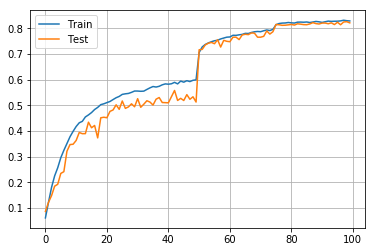

In [35]:
resnet = CifarResNet()
%time train_network(resnet, torch.device(DEVICE))

# Важно переключить сеть в режим eval - иначе dropout будет работать некорректно

In [36]:
def make_solution(a_net, a_device):
    res = []
    net = a_net.eval()
    for item in dataloader_test_norm:
        inputs = item.to(a_device)
        outputs = net(inputs) 

        res += prediction2classes(outputs)
        torch.cuda.empty_cache()
    return res

In [37]:
my_solution = make_solution(resnet, DEVICE)

In [38]:
with open('my_solution.csv', 'w') as fout:
    print('Id', 'Prediction', sep=',', file=fout)
    for i, prediction in enumerate(my_solution):
        print(i, prediction, sep=',', file=fout)